In [1]:
# Loading modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img  # To handle images

import tensorflow as tf
from tensorflow import keras

import os

## Data preprocessing

### Loading data

In [2]:
paths, words = [], []

"""
Transforming file ./ascii/words/txt as follows:
    - The first part of each line describing a word goes into the paths list
    - The last part of each line describing a word goes into the words list
"""

def path_from_code(code):
    directory, subdirectory = code.split("-")[:2]
    return os.path.join("./words", directory, directory + "-" + subdirectory, code + ".png")

file = open(f"./ascii/words.txt", "r").readlines()
np.random.shuffle(file)   # shuffling dataset
for line in file:
    if line[0] != "#" and line.split(" ")[1] == "ok":
        code = line.split(" ")[0]
        path = path_from_code(code)
        paths.append(path)
        words.append(line.split(" ")[-1][:-1])

In [4]:
# Checking lengths
len(paths), len(words)

(96456, 96456)

In [5]:
# Looking at some paths and labels
paths[:10], words[:10]

(['./words/g07/g07-030/g07-030-09-03.png',
  './words/m04/m04-113/m04-113-04-04.png',
  './words/m01/m01-115/m01-115-03-08.png',
  './words/g01/g01-067/g01-067-00-06.png',
  './words/n04/n04-009/n04-009-03-10.png',
  './words/d07/d07-100/d07-100-02-05.png',
  './words/k04/k04-010/k04-010-09-01.png',
  './words/b06/b06-087/b06-087-02-02.png',
  './words/n01/n01-020/n01-020-08-03.png',
  './words/a01/a01-128u/a01-128u-03-06.png'],
 ['him',
  'Llangrwl',
  'pretty',
  'very',
  'do',
  'by',
  'that',
  'at',
  'surface',
  'to'])

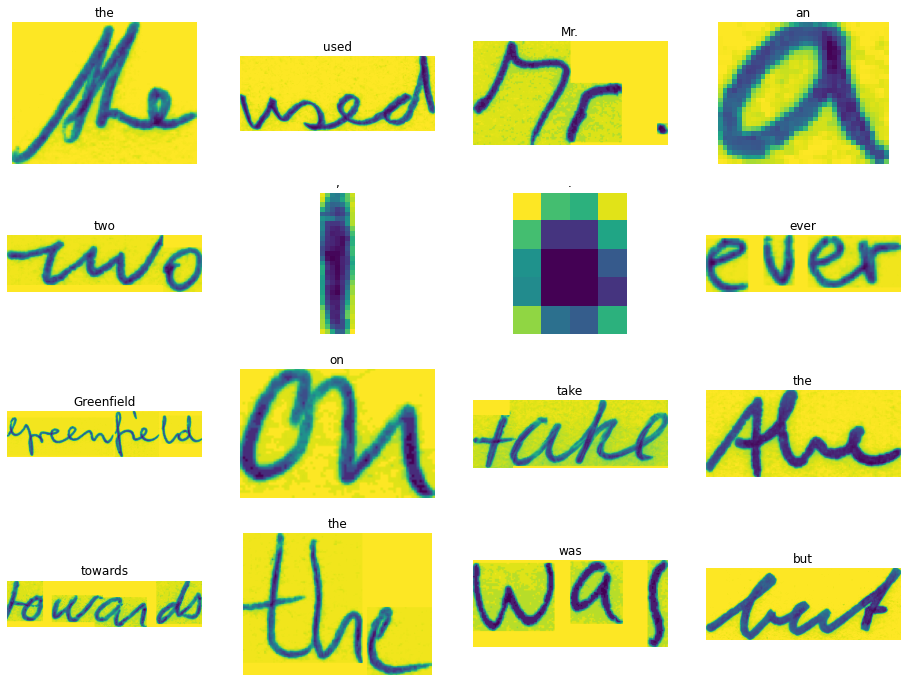

In [7]:
# Showing some random images

fig, ax = plt.subplots(4, 4, figsize=(16, 12))

for i in range(4):
    for j in range(4):
        while True:
            try:
                # Choosing random piece of data
                t = np.random.randint(0, len(words))
                # Selecting image and label
                image = img.imread(paths[t])
                label = words[t]

                ax[i, j].imshow(image)
                ax[i, j].set_title(label)
                ax[i, j].axis("off")
                break
            except:
                SyntaxError


plt.show()

### Splitting data

In [8]:
# Setting the proportion of the dataset to be used for training
# The remaining part of the dataset will be divided on validation and testing
train_size = 0.9

In [10]:
train_len = int(train_size * len(words))
validation_len = int((1 - train_size) * len(words) / 2)

training_samples, training_labels = paths[:train_len], words[:train_len]
validation_samples, validation_labels = paths[train_len:train_len+validation_len], words[train_len:train_len+validation_len]
testing_samples, testing_labels = paths[train_len+validation_len:], words[train_len+validation_len:]

print("Training size", len(training_labels))
print("Validation size", len(validation_labels))
print("Testing size", len(testing_labels))

Training size 86810
Validation size 4822
Testing size 4824


### Data preprocessing

In [11]:
# Checking that validation and testing images have the right format

i = 0
while i < len(validation_samples):
    try:
        image_path = validation_samples[i]
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)
        i += 1
    except:
        validation_samples.pop(i)
        validation_labels.pop(i)
        
i = 0
while i < len(testing_samples):
    try:
        image_path = testing_samples[i]
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)
        i += 1
    except:
        testing_samples.pop(i)
        testing_labels.pop(i)
        
print("Validation size", len(validation_labels))
print("Testing size", len(testing_labels))

Validation size 4820
Testing size 4824


#### Processing images

In [12]:
# Finding maximum image height and maximum image width in training dataset, and checking images have the right format
max_image_height, max_image_width = 0, 0

i = 0
while i < len(training_samples):
    try:
        image_path = training_samples[i]
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, 1)
        max_image_height = max(max_image_height, tf.shape(image)[0])
        max_image_width = max(max_image_width, tf.shape(image)[1])
        i += 1
    except:
        training_samples.pop(i)
        training_labels.pop(i)
        
print("Training size", len(training_labels))

print("Maximum image heigth:", max_image_height.numpy())
print("Maximum image width:", max_image_width.numpy())

Training size 86810
Maximum image heigth: 241
Maximum image width: 1087


In [14]:
def resize_image(image, target_width, target_height):
    
    # Resizing
    image = tf.image.resize(image, size = (target_height, target_width), preserve_aspect_ratio=True)
    
    # Padding
    padding_top = (target_height - tf.shape(image)[0])//2
    padding_bottom = target_height - tf.shape(image)[0] - padding_top
    padding_left = (target_width - tf.shape(image)[1])//2
    padding_right = target_width - tf.shape(image)[1] - padding_left
    
    paddings = [[padding_top, padding_bottom],
                [padding_left, padding_right],
                [0, 0]]
    
    image = tf.pad(image, paddings=paddings)
    
    return image

In [16]:
def rotate_image_right(image):
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def rotate_image_left(image):
    image = rotate_image_right(image)
    image = rotate_image_right(image)
    image = rotate_image_right(image)
    return image

In [17]:
def process_image(path, target_width, target_height):
    
    # Loading image using tensorflow
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, 1)
    
    # Resizing
    image = resize_image(image, target_width, target_height)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Rotating
    image = rotate_image_right(image)
    
    return image

./words/g06/g06-026f/g06-026f-01-06.png
de


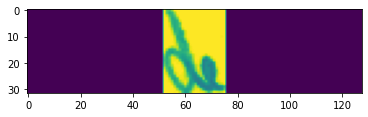

In [18]:
# Vizualising resized image

t = np.random.randint(0, len(training_samples))
plt.imshow(rotate_image_left(process_image(training_samples[t], 128, 32)))
print(training_samples[t])
print(training_labels[t])

#### Processing labels

In [19]:
# Finding max word length and set of used characters
vocabulary = set()
max_word_len = 0

for label in training_labels:
    max_word_len = max(len(label), max_word_len)
    for character in label:
        vocabulary.add(character)
        
print("Maximum word length", max_word_len)
print("Used vocabulary", vocabulary)

Maximum word length 21
Used vocabulary {'l', '7', 'U', 'x', 'X', 'y', 'M', '9', 'V', 's', '*', '-', 'b', '0', ':', '8', 'c', '+', 'B', 'R', 'v', 'A', "'", 'C', '/', 'w', 'n', '.', 'Q', 'g', 'E', 'D', 'j', 'z', 'Y', 'K', 'e', 'd', '1', ';', 'S', '!', '3', ',', '&', 'h', 'G', 'L', 'Z', 'p', '(', 'k', 'q', 'r', ')', 'f', 'H', 'P', '4', 'm', 'F', 'o', 'T', 'O', '6', '"', 'i', 'u', 'W', 'N', 't', 'I', '?', 'a', '5', 'J', '#', '2'}


In [20]:
# Creating an encoding system for vocabulary using tensorflow StringLookup

# Encode character to integer
encode_character = keras.layers.experimental.preprocessing.StringLookup(vocabulary=list(vocabulary), mask_token=None)
# Decode integer to character
decode_character = keras.layers.experimental.preprocessing.StringLookup(vocabulary=encode_character.get_vocabulary(), mask_token=None, invert=True)

In [21]:
def process_label(label, padding_token=99):
    # We start by vectorizing our label
    label_split = encode_character(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # Size of the padding needed
    missing = max_word_len - tf.shape(label_split)[0]
    padding = [[0, missing]]
    # Padding label
    label_split_padded = tf.pad(label_split, paddings=padding, constant_values=padding_token)
    return label_split_padded

In [22]:
# Get original word label from padded tensor label

def deprocess_label(label_tensor, padding_token=99):
    without_token = tf.where(tf.math.not_equal(label, padding_token))
    label_characters = tf.gather(label, without_token)
    label_str_tensor = tf.strings.reduce_join(decode_character(label_characters))
    label_str = label_str_tensor.numpy().decode('UTF-8')
    return label_str

In [23]:
# Vizualising processed label

t = np.random.randint(0, len(training_samples))
print(training_samples[t])
print(training_labels[t])
print(process_label(training_labels[t]))

./words/l04/l04-066/l04-066-06-08.png
,
tf.Tensor([44 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99], shape=(21,), dtype=int64)


#### Processing datasets

In [24]:
# Setting processing parameters
batch_size = 64

# Image resize parameters
image_width = 128
image_height = 32

# Label paddig parameters
padding_token = 99

In [26]:
testing_samples[70], testing_labels[70]

('./words/b02/b02-102/b02-102-01-01.png', 'weighing')

In [27]:
def process_data(path, label):
    image = process_image(path, target_width=image_width, target_height=image_height)
    label = process_label(label, padding_token=padding_token)
    return {"sample": image, "label":label}

def process_dataset(samples, labels):
    """
    Source:
    https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/handwriting_recognition.ipynb
    """
    dataset = tf.data.Dataset.from_tensor_slices((samples, labels)).map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [29]:
# Preprocessing the 3 datasets: training, validation and testing

training_dataset = process_dataset(training_samples, training_labels)
validation_dataset = process_dataset(validation_samples, validation_labels)
testing_dataset = process_dataset(testing_samples, testing_labels)

In [30]:
# Checking shapes
for data in training_dataset.take(1):
    print(tf.shape(data['sample']))
    print(tf.shape(data['label']))

tf.Tensor([ 64 128  32   1], shape=(4,), dtype=int32)
tf.Tensor([64 21], shape=(2,), dtype=int32)


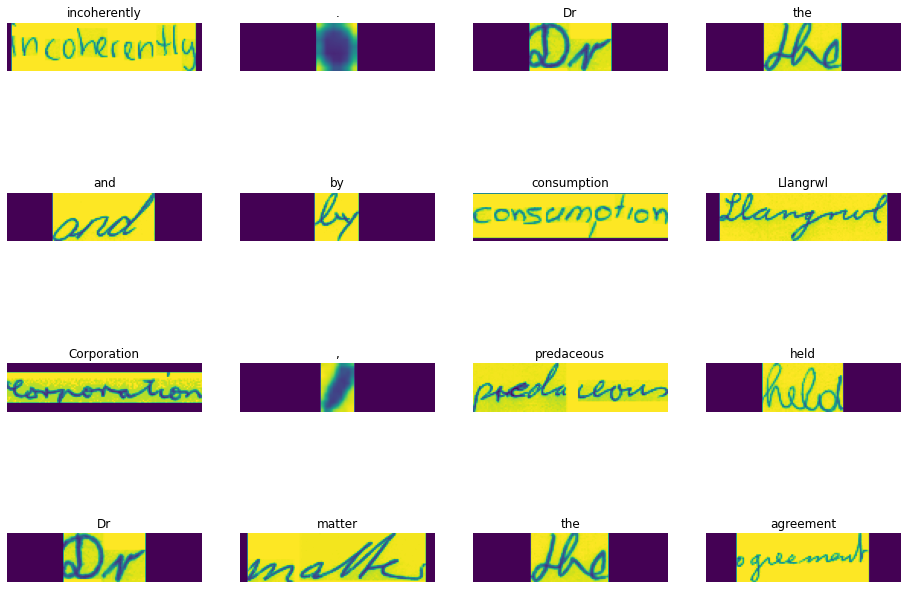

In [31]:
# Showing some random words from training set

fig, ax = plt.subplots(4, 4, figsize=(16, 12))

for i in range(4):
    for j in range(4):
        # Choosing random piece of data
        batch = list(training_dataset.take(1))[0]
        # Selecting image and label
        t = np.random.randint(0, batch_size)
        image = batch["sample"][t]
        label = batch["label"][t]
        
        label_str = deprocess_label(label)

        ax[i, j].imshow(rotate_image_left(image))
        ax[i, j].set_title(label_str)
        ax[i, j].axis("off")


plt.show()

## Model

### CTC loss layer

In [32]:
# Using keras CTC layer
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

### Model: CNN - RNN - CTC

In [34]:
def OCR_model():
    
    # Input layer
    input_img = keras.Input(shape=(image_width, image_height, 1), name="sample")
    labels = keras.layers.Input(name="label", shape=(None,))
    

    # CNN
    x = keras.layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same")(input_img)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same")(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    # After using two convolutional blocks, image size has been divided by four
    new_shape = ((image_width // 4), (image_height // 4) * 64)

    # Adding a dense layer to reduce the number of parameters used for training
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="reduction")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    # x = keras.layers.Dense(len(encode_character.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
    x = keras.layers.Dense(len(vocabulary) + 2, activation="softmax", name="output")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="CTC_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [35]:
model = OCR_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sample (InputLayer)            [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 32, 32)  320         ['sample[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 16, 64)   18496       ['max_poolin

### Evaluation Metric: Edit distance

In [36]:
# Setting validation to compute edit distance between batch prediction and batch labels
validation_images = []
validation_labels = []

for batch in validation_dataset:
    validation_images.append(batch["sample"])
    validation_labels.append(batch["label"])

In [37]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_word_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"\nMean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [38]:
# Prediction model

prediction_model = keras.models.Model(
    model.get_layer(name="sample").input, model.get_layer(name="output").output
)

edit_distance_callback = EditDistanceCallback(prediction_model)

### Training

In [39]:
# Set the number of epochs
epochs = 25

# Training OCR
history = model.fit(training_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    callbacks = [edit_distance_callback]
                    )

Epoch 1/25
1357/1357 [==============================] - ETA: 0s - loss: 13.4983
Mean edit distance for epoch 1: 20.3673
1357/1357 [==============================] - 165s 119ms/step - loss: 13.4983 - val_loss: 11.5295
Epoch 2/25
1357/1357 [==============================] - ETA: 0s - loss: 10.5737
Mean edit distance for epoch 2: 20.0409
1357/1357 [==============================] - 152s 112ms/step - loss: 10.5737 - val_loss: 9.3864
Epoch 3/25
1357/1357 [==============================] - ETA: 0s - loss: 8.8738
Mean edit distance for epoch 3: 19.7041
1357/1357 [==============================] - 153s 112ms/step - loss: 8.8738 - val_loss: 7.5719
Epoch 4/25
1357/1357 [==============================] - ETA: 0s - loss: 7.1331
Mean edit distance for epoch 4: 18.8238
1357/1357 [==============================] - 153s 113ms/step - loss: 7.1331 - val_loss: 5.6417
Epoch 5/25
1357/1357 [==============================] - ETA: 0s - loss: 5.7089
Mean edit distance for epoch 5: 18.4229
1357/1357 [=========

## Testing

In [41]:
batch = list(testing_dataset.take(3))[0]
batch_images = batch["sample"]

preds = prediction_model.predict(batch_images)

In [42]:
# Decoding batch predictions
def decode_batch_pred(prediction):
    n_samples = np.ones(tf.shape(prediction)[0]) * tf.shape(prediction)[1].numpy()
    results = keras.backend.ctc_decode(prediction, input_length=n_samples, greedy=True)[0][0][:, :max_word_len]
    sample_str = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(decode_character(res)).numpy().decode("utf-8")
        sample_str.append(res)
    return sample_str

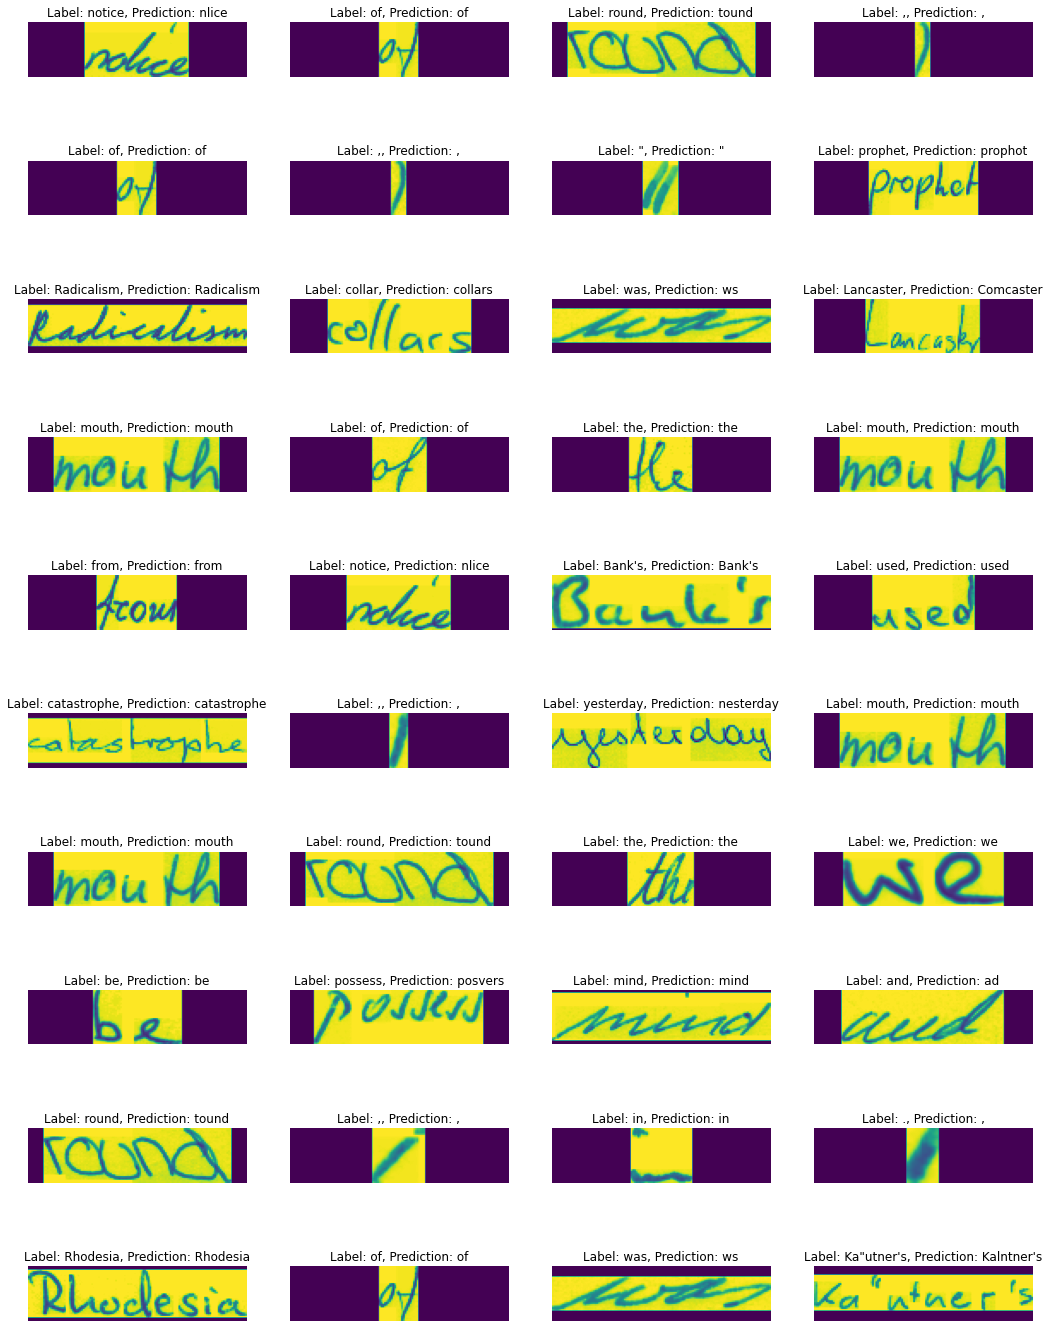

In [43]:
# Plotting some testing example images with predictions

fig, ax = plt.subplots(10, 4, figsize=(18, 25))

for i in range(10):
    for j in range(4):
        # Choosing random piece of data
        batch = list(testing_dataset.take(1))[0]
        # Selecting image and label
        t = np.random.randint(0, batch_size)
        image = batch["sample"][t]
        
        # Label
        label = batch["label"][t]
        label_str = deprocess_label(label)
        
        # Prediction
        batch_predictions = prediction_model.predict(batch["sample"])
        batch_predictions_str = decode_batch_pred(batch_predictions)
        prediction_str = batch_predictions_str[t]

        ax[i, j].imshow(rotate_image_left(image))
        ax[i, j].set_title(f'Label: {label_str}, Prediction: {prediction_str}')
        ax[i, j].axis("off")
        
plt.show()

## Live demo

In [45]:
paths = ['./demo/interview.png',
         './demo/plz.png',
         './demo/dont.png',
         './demo/disturb.png']

In [46]:
def recognize_handwritten(paths):
    
    n = len(paths)
    
    labels = ['' for _ in paths]
    ds = process_dataset(paths, labels)
    
    batch = list(ds.take(1))[0]
    batch_predictions = prediction_model.predict(batch["sample"])
    batch_predictions_str = decode_batch_pred(batch_predictions)
    
    fig, ax = plt.subplots(n, 1, figsize=(18, 3 * n))

    for i in range(n):
        
        # Selecting image and label
        t = np.random.randint(0, batch_size)
        image = batch["sample"][i]

        # Prediction
        prediction_str = batch_predictions_str[i]

        ax[i].imshow(rotate_image_left(image))
        ax[i].set_title(f'Prediction: {prediction_str}')
        ax[i].axis("off")

    plt.show()

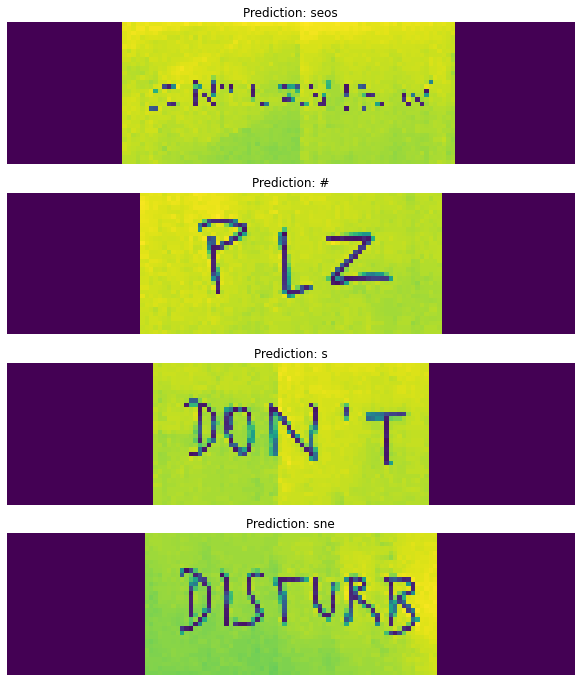

In [47]:
recognize_handwritten(paths)